In [23]:
import mdtraj as md
import functions as funcs
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

In [76]:
protein = 'Villin'
feature = 'logit(dist.)'
select_method = 'VAMP_and_Gap'
states = [0, 1, 2]
directory = 'compare_structures'

In [77]:
state_samples = {}
for state in states: 
    traj_path = Path(directory).joinpath(protein, f"{select_method}_model_{feature}_state_{state}.xtc")
    top_path = Path(directory).joinpath(protein, 'top.pdb')
    state_samples[state] = md.load(str(traj_path), top=str(top_path))

In [78]:
def rmsd_compare(traj1, traj2, selection='name CA'):
    ix1 = traj1.top.select(selection)
    ix2 = traj2.top.select(selection)
    frames = np.arange(traj2.n_frames)
    rmsd = np.concatenate([md.rmsd(traj1, traj2, frame=frame, atom_indices=ix1, ref_atom_indices=ix2) for frame in frames])
    return rmsd

# RMSD distribution analysis

In [79]:
all_dfs = []
for i in range(len(states)):
    for j in range(i, len(states)):
        state1 = states[i]
        state2 = states[j]
        rmsd = rmsd_compare(state_samples[state1], state_samples[state2])*10
        df = pd.DataFrame(rmsd, columns=['rmsd'])
        df['state_i'] = state1
        df['state_j'] = state2
        all_dfs.append(df)
df = pd.concat(all_dfs)

In [80]:
df.head()

,rmsd,state_i,state_j
0,0.000000,0,0
1,10.580034,0,0
2,9.372444,0,0
3,9.383264,0,0
4,6.983998,0,0


In [81]:
df['label'] = df.apply(lambda x: str(int(x['state_i']))+'-'+str(int(x['state_j'])), axis=1)

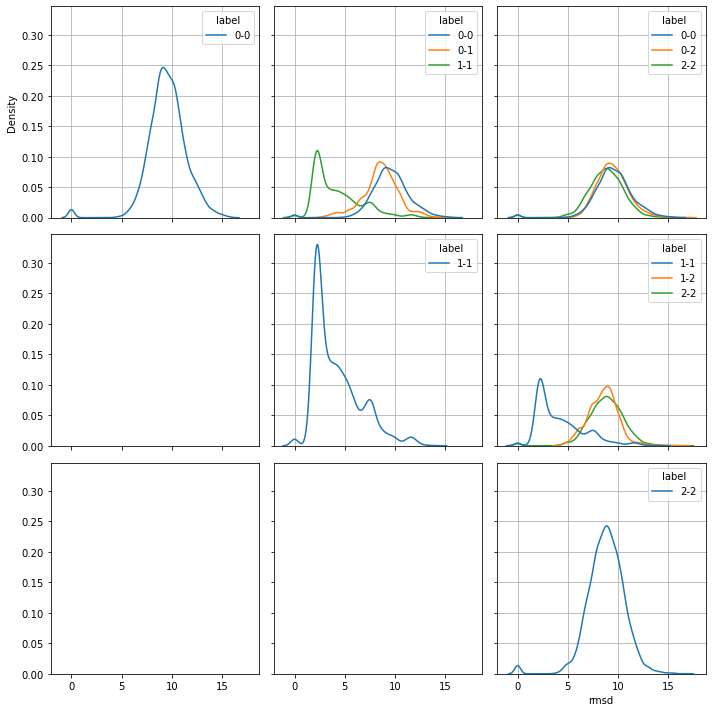

In [82]:
fig, axes = plt.subplots(len(states), len(states), sharex=True, sharey=True, figsize=(10, 10))

for i in range(len(states)):
    for j in range(i, len(states)):
        ax = axes[i, j]
        tmp = df.loc[df.label.isin([f"{states[i]}-{states[i]}", f"{states[j]}-{states[j]}", f"{states[i]}-{states[j]}"]), :]
        sns.kdeplot(data=tmp,x='rmsd',  ax=ax, hue='label')
        ax.grid()
plt.tight_layout()